In [1]:
import numpy as np
from numpy.random import rand, binomial, choice
import matplotlib.pyplot as plt

If I toss a coin 10 times, and 6 of them comes up heads, would you think the coin is biased? What if I toss 100 times and 60 of them comes as heads? What if I toss 1000 times and 600 of them comes as heads?

In [2]:
head_probability = 0.5 # change to 0.6
tosses = 10 # change to 100, 1000, 10000

results = []
for _ in range(0, tosses):
    is_heads = 1 if rand() < head_probability else 0
    results.append(is_heads)
        
print(results)
print("heads", np.sum(results))

[1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
heads 5


In [4]:
# numpy.random.binomial(n, p, size)
binomial(1, head_probability, size=tosses)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

mean 50.105
max 67


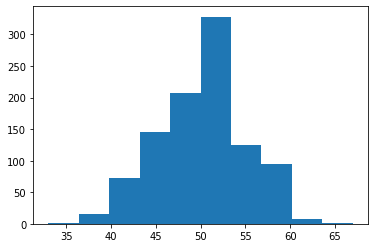

In [12]:
tosses = 100 # change to 1000
head_probability = 0.5 # change to 0.6 later

all_heads = []
for _ in range(0, 1000): # change to 10_000, then 100_000
    heads = binomial(1, head_probability, size=tosses).sum()
    all_heads.append(heads)

plt.hist(all_heads);
mean = np.mean(all_heads)
print("mean", mean)
print("max", max(all_heads))

In [11]:
low_ci = mean - np.std(all_heads) * 2
high_ci = mean + np.std(all_heads) * 2
print("confidence interval", low_ci, "-", high_ci)

print("within ci", len([ x for x in all_heads if x > low_ci and x < high_ci ]) / len(all_heads), "%")

confidence interval 40.00249529060241 - 59.909504709397595
within ci 0.943 %


So how do we compare confidence two coins? If we toss just 10 times, you won't be able to see a different between the two coins, no matter how many experiments you do with 10 tosses *incresases size*. Now, if you toss 100 times, then they start to get more different, if you toss 1000 times then the difference of which is biased and which is not is obvious

observed_difference = 1.109


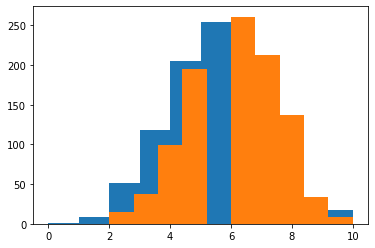

In [14]:
tosses = 10 # later change to 100, 1000

head_probability_a = 0.5
all_heads_a = []
for _ in range(0, 1000): # change to 10_000, then 100_000
    heads = binomial(1, head_probability_a, size=tosses).sum()
    all_heads_a.append(heads)

head_probability_b = 0.6
all_heads_b = []
for _ in range(0, 1000): # change to 10_000, then 100_000
    heads = binomial(1, head_probability_b, size=tosses).sum()
    all_heads_b.append(heads)
    
plt.hist(all_heads_a)
plt.hist(all_heads_b)

observed_difference = np.mean(all_heads_b) - np.mean(all_heads_a)
print("observed_difference =", observed_difference)

Intuitively, saying an experiment is "statistically significant" is exactly that! The fact that those two curves don't touch, or that they *barely* touch. But now replace "coins" with "Base or Variant" and "bias" with "conversion rate"

Let's say we have an experiment one the booking home page. We have 1000 visitors and our conversion rate is 11%, and let's say we build a new feature, a variant, which increases the conversion by 1%, that is, convertion goes up to 12%, which translates to gazillions of euros extra

ci base 94 - 127
ci variant 104 - 137
observed_difference 1.01 %


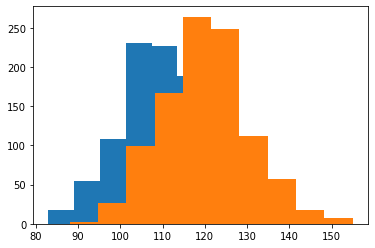

In [3]:
sample_size = 1000 # change to 10_000 later

base_convertion_rate = 0.11
bases = []
for _ in range(0, 1000): # change to 1 later
    bases.append(binomial(1, base_convertion_rate, size=sample_size))
    
variant_convertion_rate = 0.12
variants = []
for _ in range(0, 1000): # change to 1 later
    variants.append(binomial(1, variant_convertion_rate, size=sample_size))
    
sum_base = np.sum(bases, axis=1)
plt.hist(sum_base)
print("ci base", round(np.percentile(sum_base, 5)), "-", round(np.percentile(sum_base, 95)))

sum_variant = np.sum(variants, axis=1)
plt.hist(sum_variant)
print("ci variant", round(np.percentile(sum_variant, 5)), "-", round(np.percentile(sum_variant, 95)))

observed_difference = np.mean(variants) - np.mean(bases)
print("observed_difference", "%.2f" % (observed_difference * 100), "%")

But wait! We cannot run the experiment 1000 times right? Only once, what happens in this case? *changes to 1*

So how can we know, with a single run, if our experiment is statistically significant? One very cool solution to that is called "the permutation test", the basic idea of this test is: if I had this same population, with same conversion numbers, but I simply tagged different people to be in base and in variant, could I achieve same or better results?

In other words, maybe it was not our intervention, our feature, that really made a difference on this A/B test, maybe I just happened to luckly tag those good customers as "variant". To verify that, we keep the same people and their outcomes, but we randomize who was in base and who was in variant, then we calculate to see the result we would have got from it. We repeat that a thousand times, and check how many times did we get, at random, a result better than what we got with our original experiment.

So first we are going to run 1 single experiment:

In [97]:
sample_size = 1_000 # change to 10_000, then back to 1000, then to 10_000, try to get a number smaller than 1%
base = binomial(1, base_convertion_rate, size=sample_size)
variant = binomial(1, variant_convertion_rate, size=sample_size)
observed_difference = np.mean(variant) - np.mean(base)
print("observed_difference", "%.2f" % (observed_difference * 100), "%")

observed_difference 0.90 %


how many times did we randomly got a difference bigger than what we observed: 28.4 %
one-sided p-value 0.2845


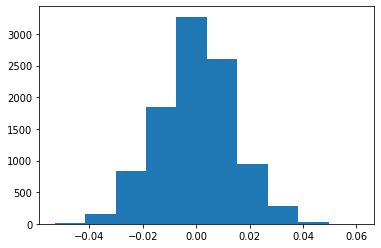

In [98]:
# start with
# (new_base, new_variant) = choice(np.concatenate((base, variant)), size=(2, sample_size), replace=False)
# new_base

# then
# simulated_difference = np.mean(new_variant) - np.mean(new_base)
# print("simulated_difference", "%.2f" % (simulated_difference * 100), "%")

differences = []

permutations = 10_000
for _ in range(0, permutations):
    (new_base, new_variant) = choice(np.concatenate((base, variant)), size=(2, len(base)), replace=False)
    simulated_difference = np.mean(new_variant) - np.mean(new_base)
    differences.append(simulated_difference)

plt.hist(differences);

times_bigger_than_observed = np.sum(np.array(differences) >= observed_difference)
print("how many times did we randomly got a difference bigger than what we observed:",
      "%.1f" % (times_bigger_than_observed / permutations * 100), "%")
print("one-sided p-value", times_bigger_than_observed / permutations)

That's it, this is the p-value! Again: the chance that we get, by random, the same or greater result as our experiment did. We want to reduce this value, we want there to be almost no chance to get this result by luck, to say, with confidence, that our intervation made a difference *change to 10_000*

It is a convention that we say our experiment is statistically significant when p < 0.05, that is, we say it is statistically significant when there is less than 5% chance that we achieved those results just by luck. On the long run, it will happen that we DID achieve it just by luck, 5% of the time we will have false positives, but 95% of the time we will be right, in theory, in practice people can game this metric but this is a different story.

There is also another explanation that goes like this, there is a default hypothesis, called the null hypothesis, that says that there is no difference between base and variant, zero. And then there is the alternative hypothesis, OUR hypothesis, that says that our intervention actually DOES have a difference, and what we are trying to do is actually to reject the null-hypothesis.

In other words, we want to say that the chance for the null-hypothesis to happen is so low, that we reject it, we would have to be very very lucky for this difference to have happened by chance. As mentiones a value of 5% is usually used, which means p-value < 0.05, so we reject it, it's like saying "I don't know exaclty how much better this is, but I know that it's not zero, I reject it, it would have to be a huge coincidence" 

Another way of achieving the p-value, easier, although maybe less obvious of why it works, is to do what we call a sampling distribution. We take make random samples out of our current sample, with replacement, many times. This will build a distribution where we can visually see if the difference between base and variant

ci base 89 - 121
ci variant 98 - 131


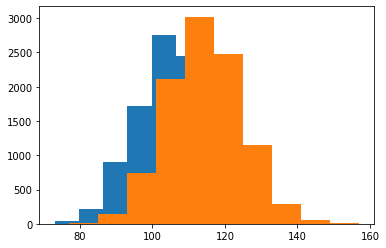

In [99]:
base_sampling = []
variant_sampling = []
for _ in range(0, 10_000):
    base_sampling.append(choice(base, sample_size, replace=True).sum())
    variant_sampling.append(choice(variant, sample_size, replace=True).sum())

plt.hist(base_sampling)
plt.hist(variant_sampling)

print("ci base", round(np.percentile(base_sampling, 5)), "-", round(np.percentile(base_sampling, 95)))
print("ci variant", round(np.percentile(variant_sampling, 5)), "-", round(np.percentile(variant_sampling, 95)))

Then to calculate the p-value we just take the difference of averages between base and variant, and then count how many times this difference was smaller than 0. If it's a low amount, say 5%, then p-value is small, which means it's very hard to get zero with those populations, so we reject the null-hypothesis that the difference is zero

how many times did we get a difference smaller than zero: 25.26 %
one-sided p-value 0.2526


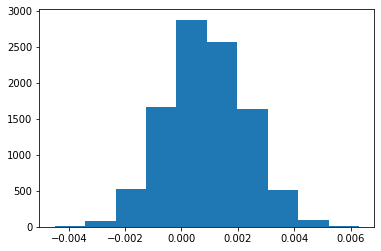

In [100]:
sampling_differences = (np.array(variant_sampling) - np.array(base_sampling)) / 10_000

times_smaller_than_zero = (np.sum(sampling_differences < 0) / 10_000)

print("how many times did we get a difference smaller than zero:", "%.2f" % (times_smaller_than_zero * 100), "%")
print("one-sided p-value", times_smaller_than_zero)
plt.hist(sampling_differences);

A third way, ever easier, and what you should actually do, is to use this library:

In [101]:
import scipy.stats as stats

stats.ttest_ind(base, variant, alternative="less").pvalue

0.25975474488601336

But! Those p-values we have above is actually just one-sided, we are only checking how many times we get randomly a value bigger than what we observed, so if we reject the null hypothesis, we can only prove there was a positive effect, but we don't know ahead of time if there would actually be a negative effect, so we need to do what they call a double-tailed p-value

In [102]:
sampling_differences_1 = (np.array(variant_sampling) - np.array(base_sampling)) / 10_000
sampling_differences_2 = (np.array(base_sampling) - np.array(variant_sampling)) / 10_000

times_smaller_than_zero_1 = (np.sum(sampling_differences_1 < 0) / 10_000)
times_smaller_than_zero_2 = (np.sum(sampling_differences_2 > 0) / 10_000)

print("p-value (sampling)", times_smaller_than_zero_1 + times_smaller_than_zero_2)

p-value (sampling) 0.5052


In [103]:
print("p-value (permutation test): ", (
    (np.sum(differences <= -observed_difference)
     + np.sum(differences >= observed_difference))
    / sampling_repetitions
))

p-value (permutation test):  0.5708


In [104]:
stats.ttest_ind(base, variant).pvalue

0.5195094897720267

As you can see the value is higher, it's harder to get statistically significant results on a double-tailed p-value, but that's what we use on A/B tests. Those one-sided p-values we use on non-inferiority tests, that's why non-inferiority are easier to be significant! Because we don't care that the intervention we are making brings positive results, we just want to be sure it doesn't bring negative ones!